<b>Comparison of deep neural network and decision tree classifier on Titanic dataset</b>

<b>Import libraries</b>

In [1]:
#Load libraries
import pandas as pd
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Define custom functions
def DisplayMetrics(y_true,pred):
    dicti_metrics = {}
    accuracy = round(accuracy_score(y_true,pred),3)
    recall = round(recall_score(y_true,pred),3)
    precision = round(precision_score(y_true,pred),3)
    f1 = round(f1_score(y_true,pred),3)
    print("accuracy: ", accuracy)
    print("recall: ", recall)
    print("precission: ", precision)
    print("F1-score: ", f1)
    print("\n confusion matrix\n",confusion_matrix(y_true,pred))
    print("\n", classification_report(y_true, pred))
    
    return {'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision], 'F1':[f1]}

#Set tf and np seeds
# tf.random.set_seed(7788)
# np.random.seed(7788)

#Print versions
print("Tensorflow version: ", tf. __version__) 
print("Numpy version",np. __version__) 

Tensorflow version:  2.11.0
Numpy version 1.24.1


<b>Load training data</b>

In [2]:
data = pd.read_csv('train.csv')
df_raw = data.copy()
df_raw.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
#Drop features that are not needed
df_raw = df_raw.drop(labels=['Name','PassengerId','Ticket'],axis=1)
df_raw.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C


<b>Explore Dataset</b>

Explore dataset, visualize its properties and see data distribution

In [4]:
df_raw.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# import seaborn as sn
# import matplotlib.pyplot as plt
# sn.heatmap(df_raw.corr(), annot=True)
# plt.show()
df_raw.corr()

C:\Users\z0040jeb\AppData\Local\Temp\ipykernel_17068\2581297007.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_raw.corr()


,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [6]:
def GetProperties(df):
    colls = []
    uniques = []
    dtype = []
    nulls = []
    df_dict = {}
    for x in df.columns:
        colls.append(x)
        uniques.append(df[x].nunique())
        dtype.append(df[x].dtype)
        nulls.append(df[x].isnull().sum())

    df_dict = {'Column':colls,'Unique':uniques,'Type':dtype,'Null':nulls}
    feature_analysis = pd.DataFrame(df_dict)
    print("Dataset Shape: ",df.shape)
    return feature_analysis

analysis = GetProperties(df_raw)
analysis

Dataset Shape:  (891, 9)


,Column,Unique,Type,Null
0,Survived,2,int64,0
1,Pclass,3,int64,0
2,Sex,2,object,0
3,Age,88,float64,177
4,SibSp,7,int64,0
5,Parch,7,int64,0
6,Fare,248,float64,0
7,Cabin,147,object,687
8,Embarked,3,object,2


In [7]:
df_raw.groupby(['Sex','Survived'])['Age'].count()

Sex     Survived
female  0            64
        1           197
male    0           360
        1            93
Name: Age, dtype: int64

In [8]:
df_raw.groupby(['Sex','Pclass'])['Age'].mean()

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

In [9]:
df_raw.groupby(['Sex','Pclass'])['Survived'].sum()

Sex     Pclass
female  1         91
        2         70
        3         72
male    1         45
        2         17
        3         47
Name: Survived, dtype: int64

In [10]:
df_raw.groupby(['Sex','Pclass','Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

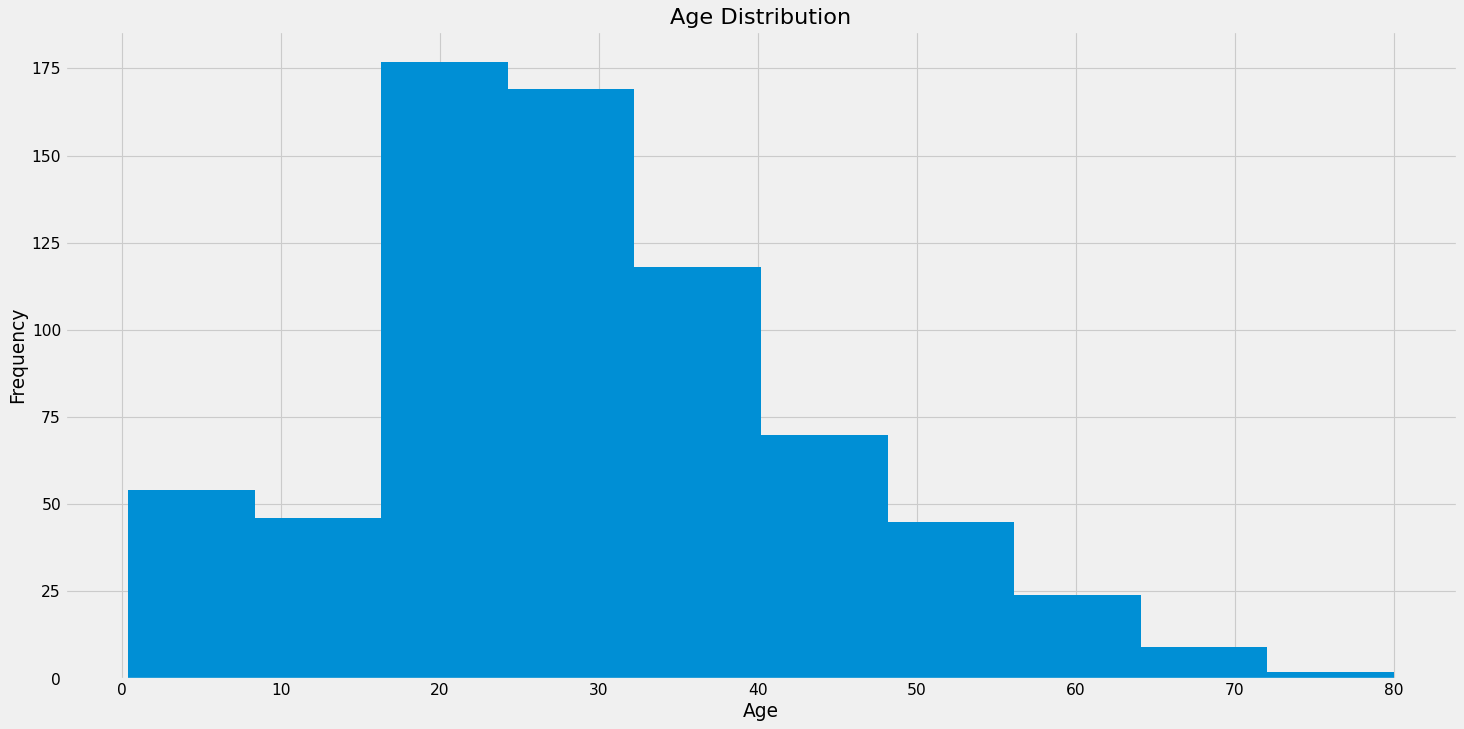

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(20, 10), dpi=80)

df_plot = df_raw

x1 = df_plot['Age']

# plot lines
plt.hist(x1)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

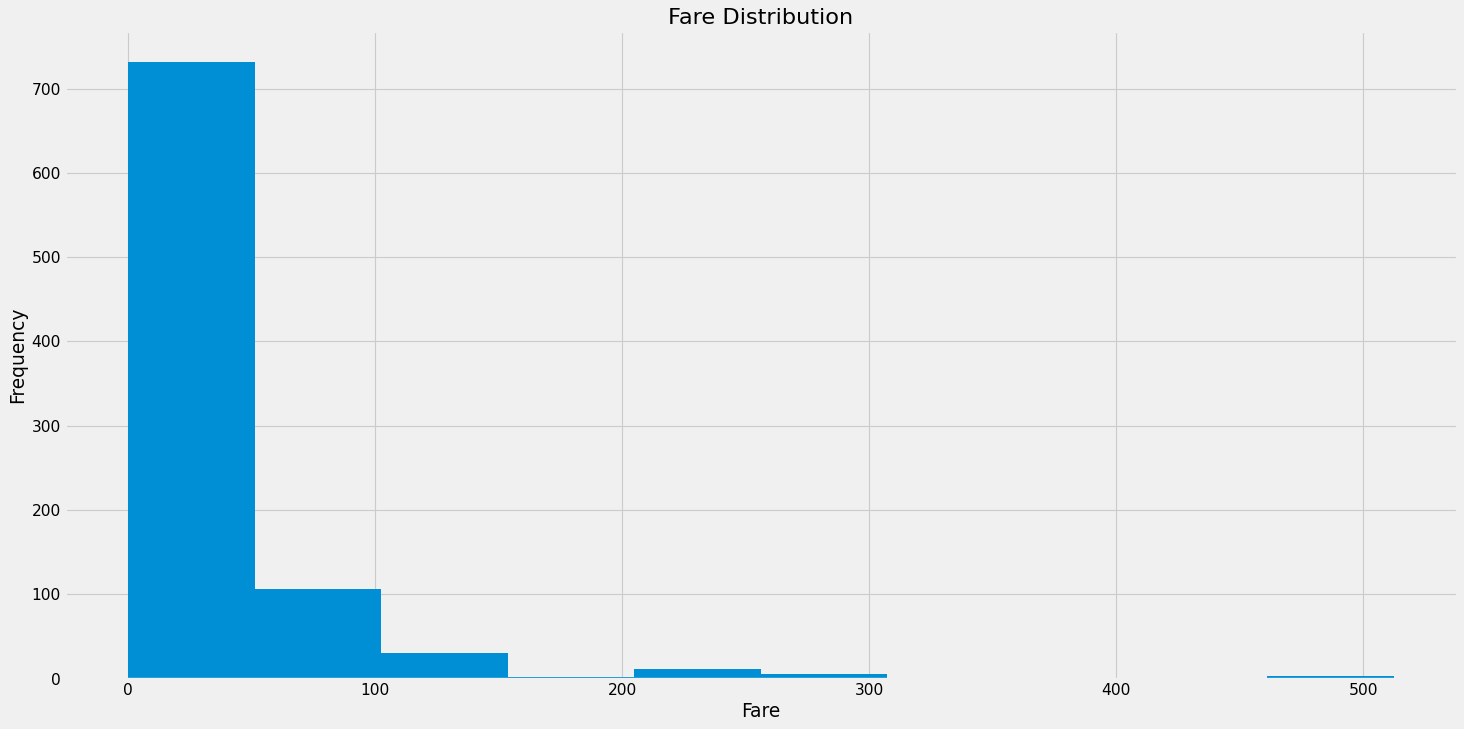

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(20, 10), dpi=80)

df_plot = df_raw

x1 = df_plot['Fare']

# plot lines
plt.hist(x1)

plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Fare Distribution')
plt.show()

0    549
1    342
Name: Survived, dtype: int64

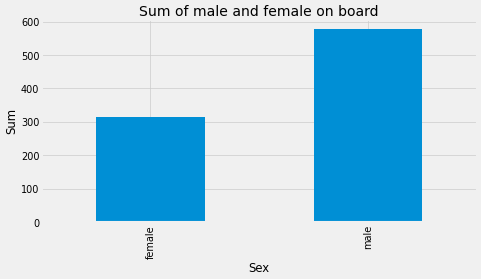

In [13]:
figure(figsize=(10, 5), dpi=50)
df_raw.groupby(['Sex'])['Pclass'].count().plot(kind='bar')
plt.title('Sum of male and female on board')
plt.xlabel('Sex')
plt.ylabel('Sum')
df_raw['Survived'].value_counts()

Sex
female    233
male      109
Name: Survived, dtype: int64

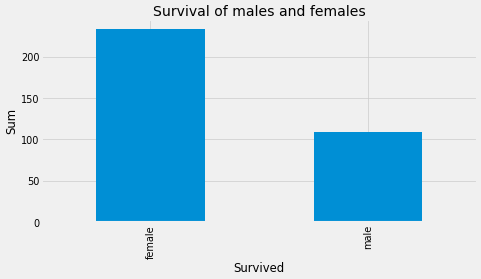

In [14]:
figure(figsize=(10, 5), dpi=50)
df_raw.groupby(['Sex'])['Survived'].sum().plot(kind='bar')
plt.title('Survival of males and females')
plt.xlabel('Survived')
plt.ylabel('Sum')
df_raw.groupby(['Sex'])['Survived'].sum()

Text(0.5, 0, 'Embarked')

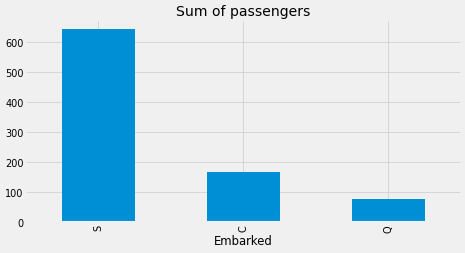

In [15]:
figure(figsize=(10, 5), dpi=50)
df_raw.Embarked.value_counts().plot(kind='bar')
plt.title('Sum of passengers')
plt.xlabel('Embarked')

<b>Handle Missing Values</b>

Handle missing values in dataset, cabin has too many missing values, it is dropped entirely, Age feature is filled with mean value with respect to standard deviation

In [16]:
df_raw.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [17]:
df_raw2 = df_raw.drop('Cabin',axis=1)

In [18]:
print("ttl nan: ",df_raw2['Embarked'].isnull().sum())
df_raw2['Embarked'].value_counts()

ttl nan:  2


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
df_raw2['Embarked'].fillna('S',inplace=True)

In [20]:
print("ttl Embarked nan: ",df_raw2['Embarked'].isnull().sum())

ttl Embarked nan:  0


In [21]:
df_raw2.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [22]:
def GetFeatureDetails(df, column):
    print("Column: ",column)
    print("max: ",df[column].max())
    print("min: ", df[column].min())
    print("mean: ", round(df[column].mean(),2))
    print("median: ", round(df[column].median(),2))
    print("Std: ", round(df[column].std(),2))
    
GetFeatureDetails(df_raw2,'Age')

Column:  Age
max:  80.0
min:  0.42
mean:  29.7
median:  28.0
Std:  14.53


In [23]:
def GetNumber(column):
    final_val = 0
    mean_val = column.mean()
    st_dev = column.std()
    
    rand = random.randint(1,50)
    rand_multiplicator = rand/100

    value = rand_multiplicator * st_dev

    if random.randint(1,2) == 1:
        final_val = mean_val - value
    else:
        final_val + value
    return final_val

GetNumber(df_raw2['Age'])

22.72639892753848

In [24]:
#Populate empty values based on above defined function
df_raw2['Age'] = df_raw2['Age'].apply(lambda x: GetNumber(df_raw2['Age']) if pd.isnull(x) == True else x)
df_raw2.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [25]:
#print count of categorical variables
categories = ['Survived','Pclass','Sex','SibSp','Parch','Embarked']
for coll in categories:
    print("Column: ",coll)
    print(df_raw[coll].value_counts())
    print("\n")

Column:  Survived
0    549
1    342
Name: Survived, dtype: int64


Column:  Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64


Column:  Sex
male      577
female    314
Name: Sex, dtype: int64


Column:  SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


Column:  Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


Column:  Embarked
S    644
C    168
Q     77
Name: Embarked, dtype: int64




<b>Feature Engineering</b>

Create new features based on existing ones

In [26]:
df_raw3 = df_raw2.copy()

df_raw3['FamilyMembers'] = df_raw2['SibSp'] + df_raw2['Parch']
df_raw3['LoneTraveller'] = df_raw3['FamilyMembers'].apply(lambda x: 1 if x == 0 else 0)
df_raw3 = df_raw3.drop(labels=['SibSp','Parch'],axis=1)
df_raw3.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyMembers,LoneTraveller
0,0,3,male,22.0,7.2500,S,1,0
1,1,1,female,38.0,71.2833,C,1,0
2,1,3,female,26.0,7.9250,S,0,1


Feature "FamilyMembers" does not have balanced distribution of classes, 3 classes (out of 9)  include nearly 90% of all observations. Bellow code is intented to increase weights of frequent classes and remove those non-frequent one. Entire code however is commented out, since it did not improve model performance on test set.

In [27]:
df_raw3.groupby(['FamilyMembers'])['Sex'].count()

FamilyMembers
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: Sex, dtype: int64

In [28]:
# print("median: ", df_raw3.groupby(['FamilyMembers'])['Sex'].count().median())
# df_raw3.groupby(['FamilyMembers'])['Sex'].count()
# dicti_ = df_raw3.groupby(['FamilyMembers'])['Sex'].count().to_dict()
# dicti_

In [29]:
# mean = df_raw3.groupby(['FamilyMembers'])['Sex'].count().mean()
# print("Mean of categorical features of family members", mean)
# threshold = mean
# df_raw3['FamilyMembers'] = df_raw3['FamilyMembers'].apply(lambda x: x if dicti_[x]>=threshold else 4) 
# df_raw3.FamilyMembers.value_counts()

In [30]:
# df_raw3.head(2)

<b>Encode Categories</b>

All categorical features are encoded to numeric form. DNN model expects values to be numerics, therefore in following part, entire dataset is being transformed. 

In [31]:
df_raw3['Sex'] = df_raw3['Sex'].apply(lambda x: 0 if x == 'male' else 1)

In [32]:
df_raw3['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [33]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
embarked_labels = le.fit_transform(df_raw3['Embarked'])

In [34]:
df_raw3['Embarked'] = embarked_labels
df_raw3

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyMembers,LoneTraveller
0,0,3,0,22.0,7.2500,2,1,0
1,1,1,1,38.0,71.2833,0,1,0
2,1,3,1,26.0,7.9250,2,0,1
3,1,1,1,35.0,53.1000,2,1,0
4,0,3,0,35.0,8.0500,2,0,1
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,13.0000,2,0,1
887,1,1,1,19.0,30.0000,2,0,1
888,0,3,1,0.0,23.4500,2,3,0
889,1,1,0,26.0,30.0000,0,0,1


<b>Get Bins</b>

Initialy i intended to create bins out of Fare and Age feature, however it did not show any improvement of model training and model performance on test set therefore bellow code is commented out.

In [35]:
# df_raw3.head(4)
# df_raw3['Age_binned'] = pd.qcut(df_raw3['Age'], 7, labels=[1, 2, 3, 4,5,6,7])
# df_raw3['Fare_binned'] = pd.qcut(df_raw3['Age'], 3, labels=[1, 2,3])
# #df_raw3 = df_raw3.drop(labels=['Age','Fare'],axis=1)
# df_raw3

In [36]:
# df_raw3['Fare_binned'].value_counts()
# #df_raw3['Fare_binned'].hist()

In [37]:
# df_raw3['Age_binned'].value_counts()

<b>Set dataframes types</b>

In [38]:
for coll in df_raw3.columns:
    if coll in ['Fare','Age']:
        df_raw3[coll] = df_raw3[coll].astype('float')
    else:
        df_raw3[coll] = df_raw3[coll].astype('category')
df_raw3.dtypes    

Survived         category
Pclass           category
Sex              category
Age               float64
Fare              float64
Embarked         category
FamilyMembers    category
LoneTraveller    category
dtype: object

<b>Normalize continuous numeric values</b>

All continuous values must be normalized in order to improve model training, for our purpose i use MinMaxScaller from sklearn library. Age and Fare are being normalized.

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaller = MinMaxScaler()
data_scalled = scaller.fit_transform(df_raw3[['Age','Fare']])
age_scalled = pd.DataFrame(data_scalled[:]).iloc[:,0]
fare_scalled = pd.DataFrame(data_scalled[:]).iloc[:,1]

df_raw3['Age'] = age_scalled
df_raw3['Fare'] = fare_scalled

<b>Get train, validation and test dataset</b>

I split dataset into train, validation and test set
- train set is used for model training
- validation set is used for training evaluation (callbacks are used to prevent overfitting).
- test set as unseen data are used at the end to check and evaluate predictions

In [40]:
df_raw3.head(2)
df_raw3 = df_raw3.drop(labels=['Fare'],axis=1)#'Embarked','FamilyMembers','Pclass'
df_raw3.head()

,Survived,Pclass,Sex,Age,Embarked,FamilyMembers,LoneTraveller
0,0,3,0,0.2750,2,1,0
1,1,1,1,0.4750,0,1,0
2,1,3,1,0.3250,2,0,1
3,1,1,1,0.4375,2,1,0
4,0,3,0,0.4375,2,0,1


In [41]:
X = df_raw3.drop(labels=['Sex'],axis=1) #,
y = df_raw3['Sex'].to_numpy()

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=7788, shuffle=True,stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.30, random_state=7788, shuffle=True,stratify=y_temp)

In [43]:
print(f"X_train shape: {X_train.shape}")
print("X_validation shape: ",X_validation.shape)
print("X_test shape: ",X_test.shape)

X_train shape: (623, 6)
X_validation shape:  (187, 6)
X_test shape:  (81, 6)


<b>Modelling part</b>

Define custom function with DNN model architecture

In [44]:
#Define callbacks that will be used during training, this improves training performance
model_name='model.h5'

metric = 'val_loss'

early_stopping = EarlyStopping(monitor=metric, patience=16, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.2,patience=4, min_lr=10e-15,verbose=1)
model_checkpoint = ModelCheckpoint(monitor=metric,filepath=model_name,save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [45]:
# tf.random.set_seed(7788)
# np.random.seed(7788)

def TrainEmbdModel(X_train):
    colls = X_train.columns
    dim_ = 2

    def DefineModel(df,columns):
        #initialize dataitems
        inputs = []
        outputs = []
        counter = 1

        #Construct Embedding Layers based on categorical features
        for coll in columns:
            uniques = df[coll].nunique()
            output_dim = df[coll].nunique()
            input_n = tf.keras.layers.Input(shape=(1, ))
            output = tf.keras.layers.Embedding(input_dim=uniques+dim_, output_dim=output_dim+dim_, name=coll,
                                              embeddings_initializer="uniform")(input_n)
            output = tf.keras.layers.Reshape(target_shape=(output_dim+dim_, ))(output)
            inputs.append(input_n)
            outputs.append(output)
            counter += 1

        #Concatenate embedding layers and construct deep nn
        x = tf.keras.layers.Concatenate()(outputs)
        x = tf.keras.layers.Dense(3,activation='elu')(x)
        x = tf.keras.layers.Dense(2,activation='selu')(x)  
        x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
        
        #Construct final model
        model = tf.keras.models.Model(inputs=inputs, outputs=x)
        #model.summary()

        return model

    model = DefineModel(X_train,colls)

    adam = tf.keras.optimizers.Adam(
                learning_rate=0.0001, beta_1=0.009, beta_2=0.999, epsilon=1e-07, amsgrad=False)

    model.compile(loss='binary_crossentropy', optimizer=adam,metrics='accuracy')#,

    model.fit([X_train[coll].to_numpy() for coll in colls],y_train,epochs=1000,
             validation_data=([X_validation[coll].to_numpy() for coll in colls], y_validation),
             callbacks=[callbacks],batch_size=1, verbose=1)#

    return model

#model = TrainEmbdModel(X_train)

In [46]:
# pred = model.predict([X_test[coll].to_numpy() for coll in X_test.columns])
# predictions = pred.round()
# _ = DisplayMetrics(y_test,predictions)


<b>Decision Tree Training</b>

Train and get prediction of classic decission tree model

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
#Initialize tree model
tree_model = DecisionTreeClassifier(random_state=1)
#Train it
tree_model = tree_model.fit(X_train, y_train)
#Predict
pred = tree_model.predict(X_test)

In [49]:
#Get metrics
tree_metrics = DisplayMetrics(y_test,pred)
df_tree = pd.DataFrame(tree_metrics)
df_tree

accuracy:  0.741
recall:  0.714
precission:  0.606
F1-score:  0.656

 confusion matrix
 [[40 13]
 [ 8 20]]

               precision    recall  f1-score   support

           0       0.83      0.75      0.79        53
           1       0.61      0.71      0.66        28

    accuracy                           0.74        81
   macro avg       0.72      0.73      0.72        81
weighted avg       0.75      0.74      0.74        81



,Accuracy,Recall,Precision,F1
0,0.741,0.714,0.606,0.656


<b>Neral Network Training</b>

Following code trains and gets metrics of DNN model. Due to stochastic behaviour of neural network  each new training might have slighly different prediction and thus metrics may vary a bit, therefore i am training model several times and at the end i calculate mean of metrics of all iterations. This mean is used to compare neural network with decission tree model.

In [50]:
# tf.random.set_seed(7788)
# np.random.seed(7788)

#initiate data items
df_final=pd.DataFrame()
colls = X_test.columns

#loop several iterations and get metrics
for iteration in range(5):
    model_emb=TrainEmbdModel(X_train)
    pred=model_emb.predict([X_test[coll].to_numpy() for coll in colls])
    predictions=pred.round()
    metrics=DisplayMetrics(y_test,predictions)
    df=pd.DataFrame(metrics)
    df_final=df_final.append(df)

#Calculate means and create dataframe
df_final['Iteration'] = [x for x in range(len(df_final))]      
Accuracy = df_final.Accuracy.mean()
Recall = df_final.Recall.mean()
Precision = df_final.Precision.mean()
F1 = df_final.F1.mean()
dicti = {'Iteration':'Mean','Accuracy':[Accuracy],'Recall':[Recall],'Precision':[Precision],'F1':[F1]}
df_temp = pd.DataFrame(dicti)
df_final = df_final.append(df_temp)
df_final = df_final.set_index('Iteration')
#df_final

Epoch 1/1000
623/623 [==============================] - 3s 3ms/step - loss: 0.6586 - accuracy: 0.6469 - val_loss: 0.6461 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 2/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.6364 - accuracy: 0.6469 - val_loss: 0.6315 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 3/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.6154 - accuracy: 0.6469 - val_loss: 0.6111 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 4/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.5910 - accuracy: 0.6950 - val_loss: 0.5920 - val_accuracy: 0.6845 - lr: 1.0000e-04
Epoch 5/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.5696 - accuracy: 0.7432 - val_loss: 0.5738 - val_accuracy: 0.7219 - lr: 1.0000e-04
Epoch 6/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.5485 - accuracy: 0.7496 - val_loss: 0.5563 - val_accuracy: 0.7326 - lr: 1.0000e-04
Epoch 7/1000
623/623 [============

Epoch 11/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.5036 - accuracy: 0.7785 - val_loss: 0.5274 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 12/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4951 - accuracy: 0.7929 - val_loss: 0.5222 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 13/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4888 - accuracy: 0.7929 - val_loss: 0.5192 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 14/1000
623/623 [==============================] - 2s 3ms/step - loss: 0.4842 - accuracy: 0.7897 - val_loss: 0.5170 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 15/1000
623/623 [==============================] - 2s 3ms/step - loss: 0.4805 - accuracy: 0.7849 - val_loss: 0.5155 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 16/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.4773 - accuracy: 0.7978 - val_loss: 0.5141 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 17/1000
623/623 [=====

Epoch 15/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.7897 - val_loss: 0.5096 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 16/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.4630 - accuracy: 0.7849 - val_loss: 0.5071 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 17/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4610 - accuracy: 0.7865 - val_loss: 0.5068 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 18/1000
623/623 [==============================] - 2s 3ms/step - loss: 0.4592 - accuracy: 0.7865 - val_loss: 0.5073 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 19/1000
623/623 [==============================] - 2s 3ms/step - loss: 0.4577 - accuracy: 0.7817 - val_loss: 0.5057 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 20/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.4566 - accuracy: 0.7865 - val_loss: 0.5054 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 21/1000
623/623 [=====

Epoch 23/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4608 - accuracy: 0.7913 - val_loss: 0.5052 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 24/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4595 - accuracy: 0.7865 - val_loss: 0.5062 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 25/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4585 - accuracy: 0.7833 - val_loss: 0.5055 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 26/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4574 - accuracy: 0.7865 - val_loss: 0.5055 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 27/1000
609/623 [============================>.] - ETA: 0s - loss: 0.4595 - accuracy: 0.7833
Epoch 27: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
623/623 [==============================] - 2s 3ms/step - loss: 0.4563 - accuracy: 0.7865 - val_loss: 0.5060 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 28/1000
623/623 [====

Epoch 26/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.4530 - accuracy: 0.7865 - val_loss: 0.5061 - val_accuracy: 0.7754 - lr: 4.0000e-06
Epoch 27/1000
622/623 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.7878
Epoch 27: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
623/623 [==============================] - 2s 3ms/step - loss: 0.4530 - accuracy: 0.7865 - val_loss: 0.5061 - val_accuracy: 0.7754 - lr: 4.0000e-06
Epoch 28/1000
623/623 [==============================] - 2s 2ms/step - loss: 0.4529 - accuracy: 0.7865 - val_loss: 0.5061 - val_accuracy: 0.7754 - lr: 8.0000e-07
Epoch 29/1000
623/623 [==============================] - 1s 2ms/step - loss: 0.4529 - accuracy: 0.7865 - val_loss: 0.5061 - val_accuracy: 0.7754 - lr: 8.0000e-07
Epoch 30/1000
623/623 [==============================] - 2s 3ms/step - loss: 0.4528 - accuracy: 0.7865 - val_loss: 0.5061 - val_accuracy: 0.7754 - lr: 8.0000e-07
Epoch 31/1000
606/623 [=====

,Accuracy,Recall,Precision,F1
Iteration,,,,
0,0.827,0.786,0.733,0.759
1,0.827,0.786,0.733,0.759
2,0.827,0.786,0.733,0.759
3,0.827,0.786,0.733,0.759
4,0.827,0.786,0.733,0.759
Mean,0.827,0.786,0.733,0.759


<b>Evaluate and compare both models</b>

In [54]:
#Create dataframe for comparison of classic Tree model and Neural Network with embedding layers
a = df_final.tail(1)
b = a.reset_index()
c=b.iloc[:,1:]
d = c.transpose()
tree_a = df_tree.transpose()
df_comparison = pd.concat([d,tree_a],axis=1)
df_comparison.columns = ['NeuralNetwork','DecissionTree']
df_comparison

,NeuralNetwork,DecissionTree
Accuracy,0.827,0.741
Recall,0.786,0.714
Precision,0.733,0.606
F1,0.759,0.656


<b>Plot comparison on a barchart</b>

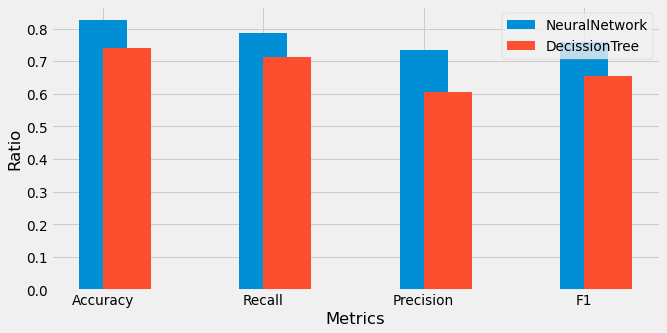

In [55]:
fig, ax = plt.subplots(figsize=(10,5), dpi=70)
NeuralNetwork = ax.bar(df_comparison.index,df_comparison['NeuralNetwork'],
                 0.3, label="NeuralNetwork")
DecissionTree = ax.bar(df_comparison.index,df_comparison['DecissionTree'], 0.3,
                label="DecissionTree",align='edge')


ax.set_xlabel('Metrics')
ax.set_ylabel('Ratio')
ax.legend()
plt.show()